# MAE 20 on leaderboard

In [2]:
# Setup
## libs
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## params
%matplotlib inline
np.random.seed(0)
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

## data
test = pd.read_csv('./test.csv', index_col='Id')
dT = pd.read_csv('./train.csv', index_col='Id')
dT

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Id,,,,,,,,,,,,,
0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20


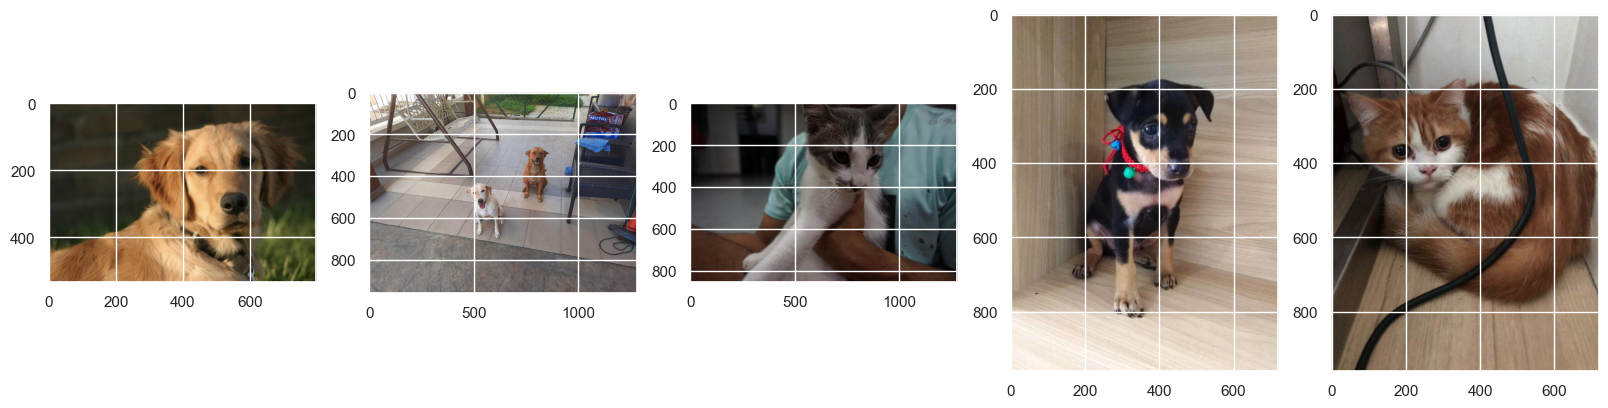

In [29]:
def show_imgs(n,df):
    for i in range(n):
        atual = '1'+str(n)+str(i+1)
        caminho = './train/'+dT.sample(n=1).index[0]+'.jpg'
        plt.subplot(int(atual))
        plt.imshow(plt.imread(caminho));

show_imgs(5,dT)

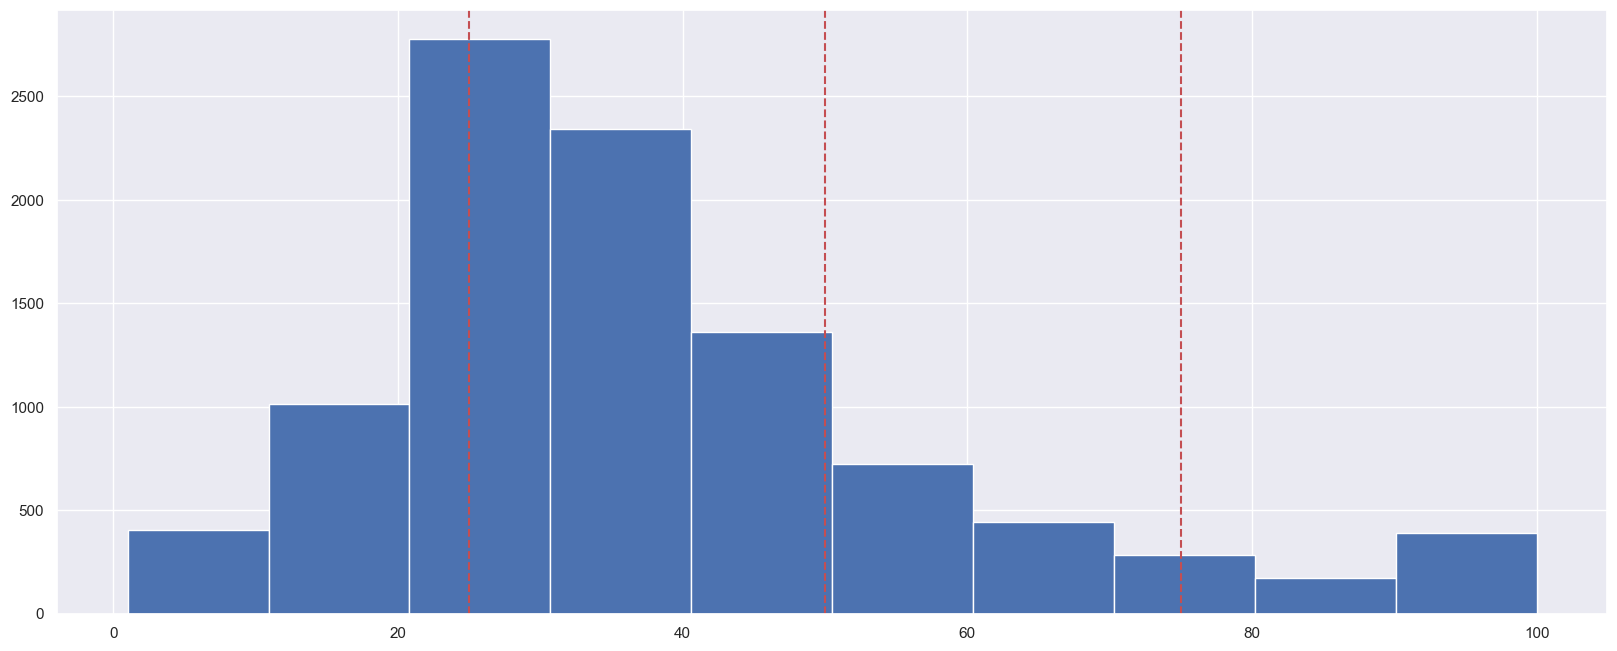

In [40]:
## Banco de Dados não é igualmente distribuido, mas uniforme:
dT['Pawpularity'].hist();
plt.axvline(x = 25,linestyle ='--', color = 'r');
plt.axvline(x = 50,linestyle ='--', color = 'r');
plt.axvline(x = 75,linestyle ='--', color = 'r');

In [54]:
# catDT.loc[catDT['Pawpularity']<=75]['']= 3
catDT['Pawpularity'].loc[catDT['Pawpularity']<=75] =  3
catDT.loc[catDT['Pawpularity']<=75]['Pawpularity']

Id
0007de18844b0dbbb5e1f607da0606e0    4
0009c66b9439883ba2750fb825e1d7db    4
0013fd999caf9a3efe1352ca1b0d937e    4
0018df346ac9c1d8413cfcc888ca8246    4
001dc955e10590d3ca4673f034feeef2    4
                                   ..
ffbfa0383c34dc513c95560d6e1fdb57    4
ffcc8532d76436fc79e50eb2e5238e45    4
ffdf2e8673a1da6fb80342fa3b119a20    4
fff19e2ce11718548fa1c5d039a5192a    4
fff8e47c766799c9e12f3cb3d66ad228    4
Name: Pawpularity, Length: 9912, dtype: int64

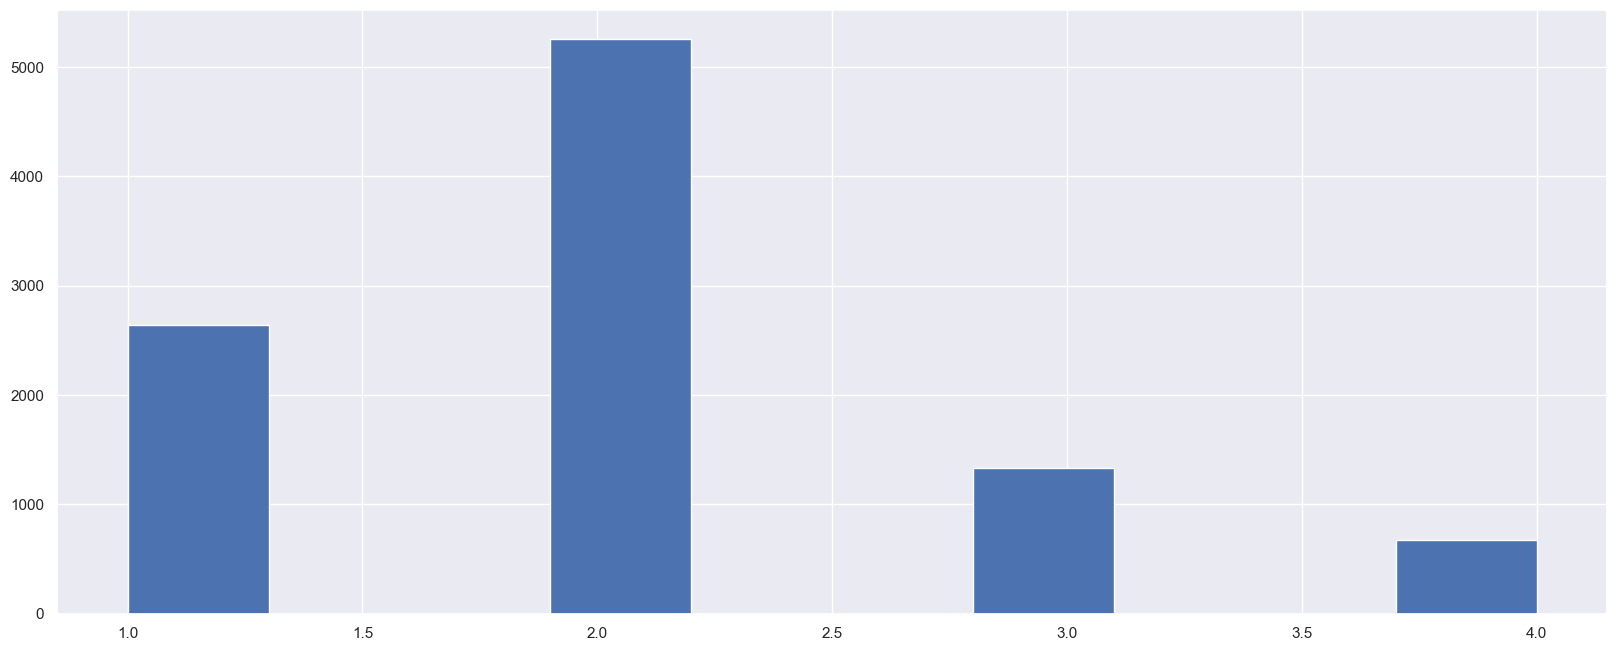

In [57]:
# Separando em 4 categorias
catDT = dT.copy()
catDT['Pawpularity'] = 4
catDT.loc[dT['Pawpularity']<=75,'Pawpularity']= 3
catDT.loc[dT['Pawpularity']<=50,'Pawpularity']= 2
catDT.loc[dT['Pawpularity']<=25,'Pawpularity']= 1
catDT['Pawpularity'].hist();

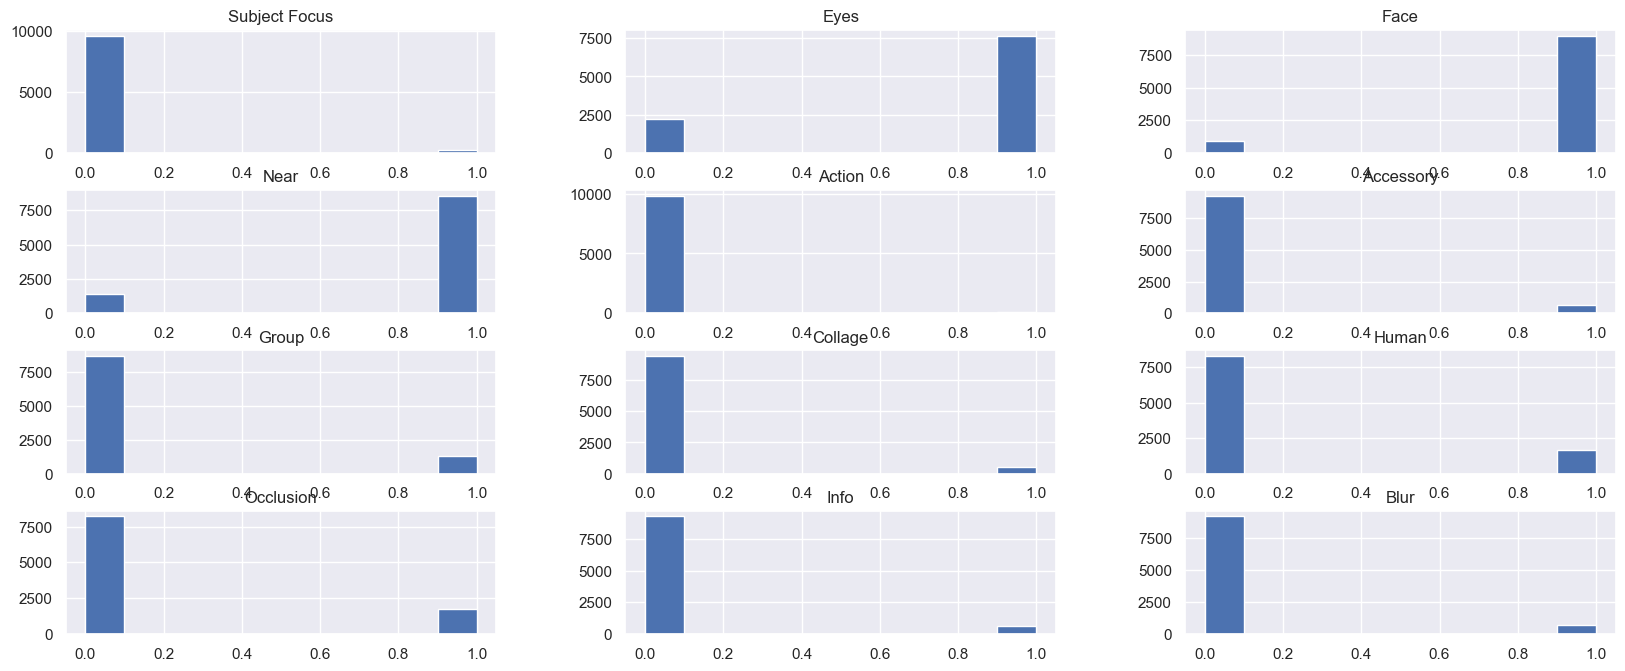

In [58]:
# Outras features também estão mal distribuidas
catDT.drop('Pawpularity',axis=1).hist();

In [139]:
# Cross validated measure of feature importance for each category:
X = dT.copy()
y = X.pop('Pawpularity')
X_test = test.copy()

from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

final_predictions = []
history =[]

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X, y)

for fold, (train_indicies, valid_indicies) in enumerate(tqdm(kf.split(X=X,y=y))):
    X_train = X.iloc[train_indicies]
    X_valid = X.iloc[valid_indicies]

    y_train = y[train_indicies]
    y_valid = y[valid_indicies]

    print('Fold:', fold+1)

    model = XGBRegressor()

    model.fit(
        X = X_train,y= y_train,eval_metric ='rmse'
    )

    # preds_valid = model.predict_proba(X_valid)
    preds_valid = model.predict(X_valid)
    history.append([fold, mean_absolute_error(y_valid,preds_valid)])

    preds_test = model.predict(X_test)
    final_predictions.append(preds_test)

    print(history[-1])


FI = pd.DataFrame({'feats':X.columns,'imp':model.feature_importances_}).sort_values(by='imp',ascending=False)
FI

0it [00:00, ?it/s]

Fold: 1


1it [00:00,  2.63it/s]

[0, 15.928728576386991]
Fold: 2


2it [00:00,  2.71it/s]

[1, 15.110689388461264]
Fold: 3


3it [00:01,  2.65it/s]

[2, 15.857907582965316]
Fold: 4


4it [00:01,  2.44it/s]

[3, 15.926847996552945]
Fold: 5


5it [00:01,  2.51it/s]

[4, 15.369352237487778]


,feats,imp
10,Info,0.133984
1,Eyes,0.105745
4,Action,0.102152
5,Accessory,0.091913
2,Face,0.088724
11,Blur,0.084749
7,Collage,0.084257
3,Near,0.075687
9,Occlusion,0.069039
6,Group,0.060279


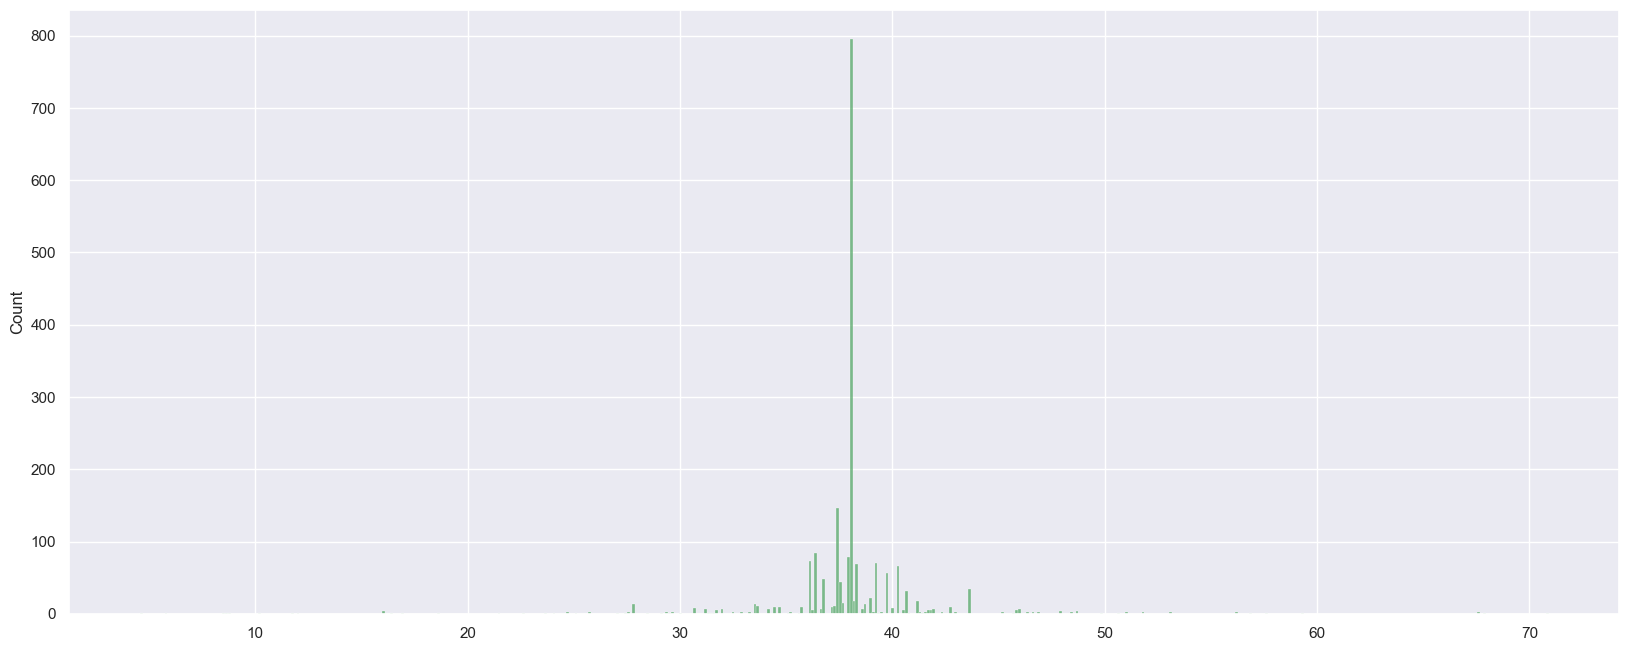

In [135]:
# Comparando resultados
sns.histplot(preds_valid, color='g');
# sns.histplot(y_valid, color ='b', alpha = 0.6);

[[0, 15.928728576386991], [1, 15.110689388461264], [2, 15.857907582965316], [3, 15.926847996552945], [4, 15.369352237487778]]
15.928728576386991


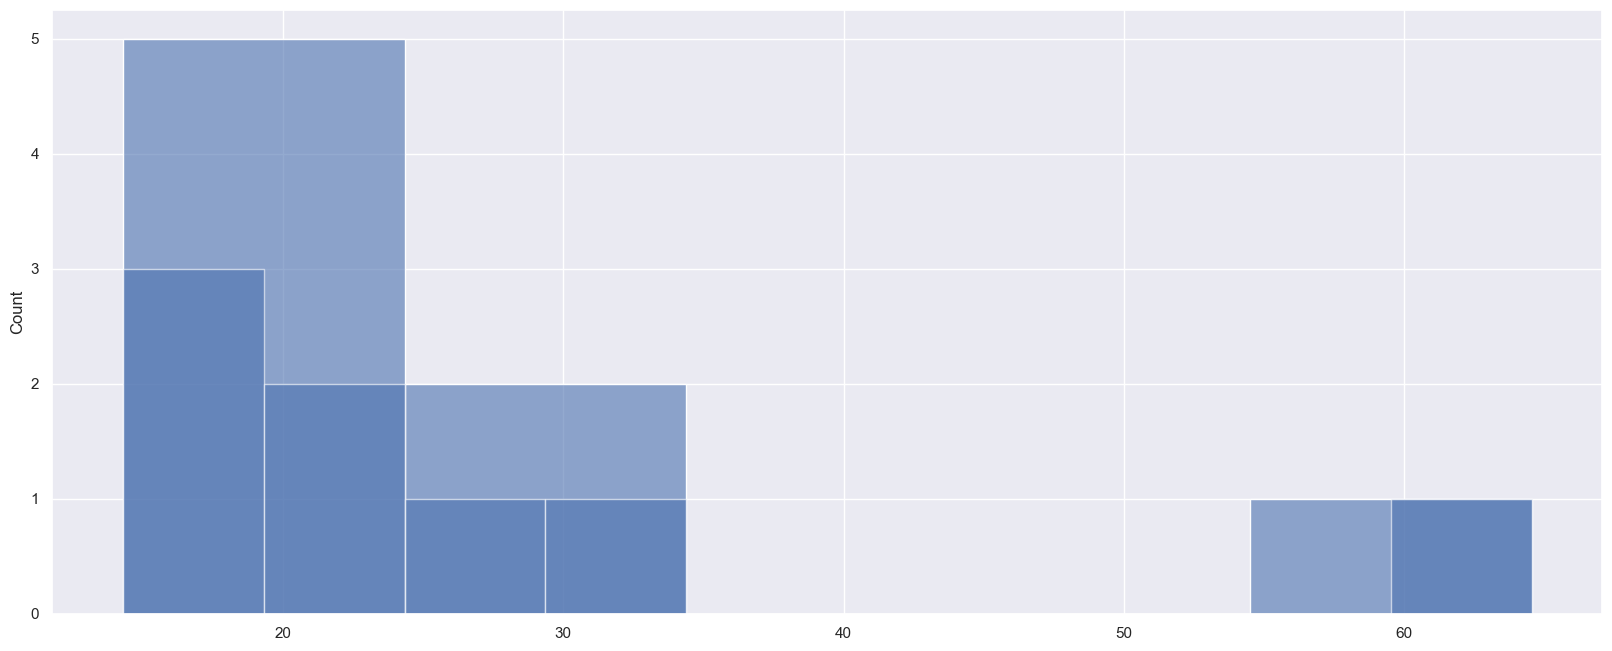

In [142]:
print(history)

maior =0.0
for ii in range(len(history)):
    if history[ii][1]>maior:
        maior = history[ii][1]
        max_index = ii

print(history[max_index][1])
sub = final_predictions[:][max_index]
sns.histplot(data = sub,alpha = 0.6)
mysub = pd.DataFrame(test.index)
mysub['Pawpularity'] = sub

mysub['Pawpularity'].hist(alpha = 0.6)

var = 'xgboost_simpleEDA_firstSub'
mysub.to_csv(var+'_submisssion.csv',index=False)